In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets
import glob

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8_kr1vcc because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def plot_closure():
    plt.show()
    plt.close()

# Dataset

In [3]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [4]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)
print(all_points.shape)
all_poses = all_points.reshape(-1,8)

# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
# scaling term doesn't affect time, so don't use time in calculation

mean = np.mean(all_poses, axis=0)
mean[0] = 0 # don't scale time
variance = np.var(all_poses[:,1:], axis=0) # don't scale time
print(mean)
print(variance)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

We found 155 pickup attempts
(155, 64, 8)
[ 0.          0.00227658 -0.00117697  0.0121782  -0.04935249  0.37343377
 -0.89429268 -0.01921521]
[2.63014114e-05 3.40430938e-05 1.00819967e-04 7.90561700e-03
 3.18947674e-02 7.03375426e-03 1.11414372e-02]
std of:  0.17859106200728153


In [5]:
print(mean, position_scaling, rotation_scaling)
def scale_dataset(input_points):
    points = input_points - mean
    poss = position_scaling
    rts = rotation_scaling
    points = (points * np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    return points

def unscale_poses(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean[1:]
    return points 
    
def unscale_dataset(input_points):
    poss = position_scaling
    rts = rotation_scaling
    points = (input_points / np.array((1,poss,poss,poss,rts,rts,rts,rts)))
    points = points + mean
    return points

[ 0.          0.00227658 -0.00117697  0.0121782  -0.04935249  0.37343377
 -0.89429268 -0.01921521] 5.599384363139225 0.895901498102276


In [6]:
dataset = scale_dataset(all_points)
t_all_points = torch.tensor(dataset,dtype=torch.float32)

## 2D VAE Fit to Dataset

In [7]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [8]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cuda"
train_loader = Loader(dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
  

In [9]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [10]:
testname = f"trainedmodels/{foodname}_"

In [11]:
all_models = []

for curvreg in [0.001,0,0.0001,0.0005]:
    for beta in [0.00001,0.0001,0.001,0.01]:
        for latentdim in [3]:
            for epsilon_scale_start in [1]:
                try:
                    savedir_pattern  = f'{testname}lat{latentdim}_curvreg{curvreg}_beta{beta}_*'

                    filenames = glob.glob(savedir_pattern)
                    #print(len(filenames))
                    for filename in filenames:
                        if 'epoch' in filename:
                            continue
                        try:
                            #print(filename)
                            textfilename = glob.glob(filename + "/model_type.txt")[0]
                            #print(textfilename)
                            all_models.append(filename)
                        except:
                            continue
                except:
                    continue

In [12]:
all_models = ['trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436']
all_models

['trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436']

In [13]:

colors=["red","yellow","green","orange","black","gray","blue"]

In [14]:
def make_start_grid_points(*, num_dims = None, t = 0, **kwargs):
    if num_dims is None:
        raise Exception("Switched this method to require num_dims as a named arg, sorry")
    num_few = 3
    num_med = 5
    num_many = 300
    pts = []
    if num_dims == 4:
        # expects args to contain ymin, ymax, zmin, zmax
        xmin = kwargs["xmin"]
        xmax = kwargs["xmax"]
        ymin = kwargs["ymin"]
        ymax = kwargs["ymax"]
        zmin = kwargs["zmin"]
        zmax = kwargs["zmax"]
        for x in np.linspace(xmin, xmax, num_few):
            for y in np.linspace(ymin, ymax, num_med):
                for z in np.linspace(zmin, zmax, num_many):
                    pts.append((t,x,y,z))
        for x in np.linspace(xmin, xmax, num_few):
            for y in np.linspace(ymin, ymax, num_many):
                for z in np.linspace(zmin, zmax, num_med):
                    pts.append((t,x,y,z))
        for x in np.linspace(xmin, xmax, num_many):
            for y in np.linspace(ymin, ymax, num_med):
                for z in np.linspace(zmin, zmax, num_med):
                    pts.append((t,x,y,z))
        return np.array(pts)

In [15]:
def get_scale(data, buffer=0.1):
    valrange = np.max(data) - np.min(data)
    return(np.min(data)-buffer*valrange,np.max(data)+buffer*valrange,)

In [16]:
def plot_start_pose(modelname, ax,plot_axes,t):
    loaded_mod = lm.load_model(modelname)
    latent_dim = loaded_mod.latent_dim
    loaded_vae = loaded_mod
    #x,mu,logvar, noisy_mu, t
    embeds = np.array([loaded_vae.forward(t_all_points[i,:1,1:], t_all_points[i,:1,:1])[1].detach().numpy() for i in range(len(t_all_points))])
    embeds = embeds[:,0,:]
    xlow,ylow,zlow = np.min(embeds,axis=0)
    xhigh,yhigh,zhigh = np.max(embeds,axis=0)
    print(ylow,zlow,yhigh,zhigh)
    sweep = make_start_grid_points(t = t,num_dims = latent_dim+1,xmin=xlow,xmax=xhigh,ymin=ylow,ymax=yhigh,zmin=zlow,zmax=zhigh)
    sweepdecodedx, sweepdecodedt = loaded_vae.decode(torch.tensor(sweep[:,1:], dtype=torch.float32),
                                     torch.tensor(sweep[:,:1], dtype=torch.float32),
                                    )
    sweepdecodedx=unscale_poses(sweepdecodedx.detach().cpu().numpy())
    sweepdecodedt=sweepdecodedt.detach().cpu().numpy()
    p=ax.scatter(sweepdecodedx[:,plot_axes[0]], sweepdecodedx[:,plot_axes[1]],  alpha=0.1);#,c=sweep[:,2])
    ax.scatter(all_points[:,int(t*64),plot_axes[0]+1], all_points[:,int(t*64),plot_axes[1]+1],  alpha=0.5,color="k",s=5);

In [17]:
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
-2.2052674 -2.2611442 2.6496553 3.121417


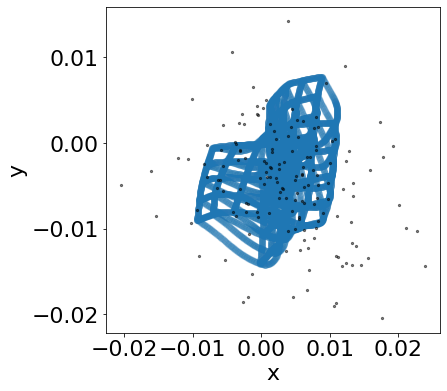

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
-2.2052674 -2.2611442 2.6496553 3.121417


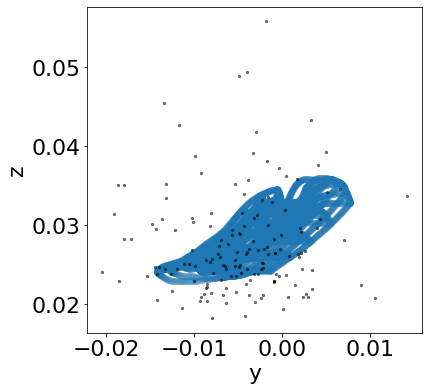

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
-2.2052674 -2.2611442 2.6496553 3.121417


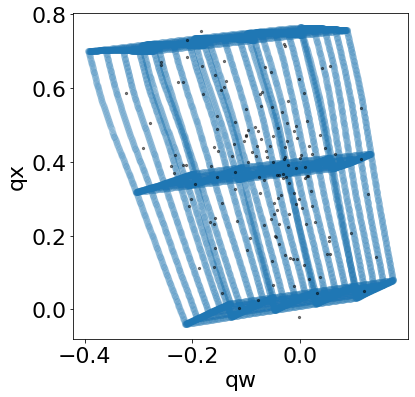

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
-2.2052674 -2.2611442 2.6496553 3.121417


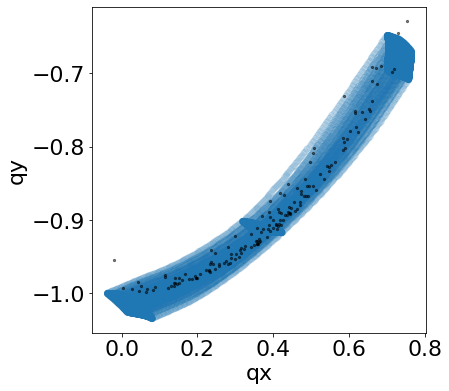

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
-2.2052674 -2.2611442 2.6496553 3.121417


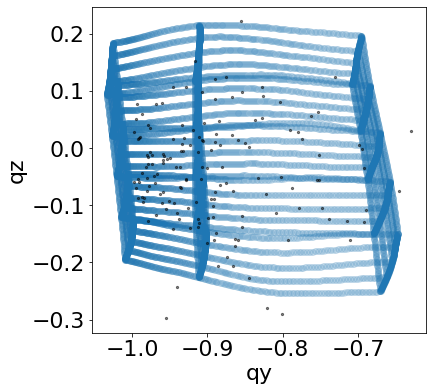

In [27]:
ax_names = ["x","y","z","qw","qx","qy","qz"]
for j in range(len(all_models)):
    for axinds in [[0,1],[1,2],[3,4],[4,5],[5,6]]:
        print(all_models[j])
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
        plot_start_pose(all_models[j], ax,axinds,t=0)
        plt.xlabel(ax_names[axinds[0]])
        plt.ylabel(ax_names[axinds[1]])
        fig.savefig(f"images/fulltraj_initfit_curvvae_{ax_names[axinds[0]]}_{ax_names[axinds[1]]}.png",
                  bbox_inches = 'tight')
        plot_closure()

In [19]:

#axis_names = ["x","y","z","qw","qx","qy","qz"]
#blue = np.array([[0,47,108]])/255
#red = np.array([[170,20,45]])/255
#
#all_models = [('const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0_es1_beta1e-05_20220208-160220', 'vae'),
#             ('const_delta_higher_curv_samp/annealepslat2_lr0.0005_curvreg0.001_es1_beta1e-05_20220208-160950', 'curvvae')
#             ]
#for modelpath, modelname in all_models:
#    for inds in [[0,1],[1,2],[3,4],[4,5]]:
#        f, axs = plt.subplots(1,1,figsize=(6,6))#,subplot_kw={'projection':'3d'})
#        print(modelpath)
#        vae = lm.load_model(modelpath)
#        embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
#                           torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
#                           )[0].detach().cpu().numpy()
#        z1min, z1max = get_scale(embeds[:,0], -0.05)
#        z2min, z2max = get_scale(embeds[:,1], -0.05)
#        pts = make_2d_grid_points(z1min, z1max, z2min, z2max)
#        readout = vae.decode(torch.tensor(pts,dtype=torch.float),
#                  torch.tensor(np.zeros((len(pts),0)),dtype=torch.float))[0].detach().cpu()
#
#        readout = unscale_dataset(readout)
#        axs.scatter(start_points[:,inds[0]],start_points[:,inds[1]], alpha=1,linewidths=0,c=blue);
#        axs.scatter(readout[:,inds[0]],readout[:,inds[1]], alpha=0.2,linewidths=0,s=10,c=red);
#        axs.axis('equal')
#        axs.set(xlim=get_scale(start_points[:,inds[0]]), ylim=get_scale(start_points[:,inds[1]]))
#        axs.set_xlabel(axis_names[inds[0]])
#        axs.set_ylabel(axis_names[inds[1]])
#        f.savefig(f"images/inital_pose_fit_{modelname}_{axis_names[inds[0]]}_{axis_names[inds[1]]}.png",
#                  bbox_inches = 'tight')
#        plot_closure()

In [20]:
def make_grid_points(*, num_dims = None, **kwargs):
    if num_dims is None:
        raise Exception("Switched this method to require num_dims as a named arg, sorry")
    num_few = 3
    num_med = 5
    num_many = 64
    pts = []
    if num_dims == 4:
        # expects args to contain ymin, ymax, zmin, zmax
        tmin = 0
        tmax = 1
        latmins = kwargs["latmins"]
        latmaxs = kwargs["latmaxs"]
        latoneind, lattwoind = kwargs["latinds"]
        latonemin = latmins[latoneind]
        lattwomin = latmins[lattwoind]
        latonemax = latmaxs[latoneind]
        lattwomax = latmaxs[lattwoind]
        #for x in np.linspace(tmin, tmax, num_few):
        #    for y in np.linspace(latonemin, latonemax, num_med):
        #        for z in np.linspace(lattwomin, lattwomax, num_many):
        #            next_to_add = np.array([x,0,0,0])
        #            next_to_add[latoneind+1] = y
        #            next_to_add[lattwoind+1] = z
        #            pts.append(next_to_add)
        #for x in np.linspace(tmin, tmax, num_few):
        #    for y in np.linspace(latonemin, latonemax, num_many):
        #        for z in np.linspace(lattwomin, lattwomax, num_med):
        #            next_to_add = np.array([x,0,0,0])
        #            next_to_add[latoneind+1] = y
        #            next_to_add[lattwoind+1] = z
        #            pts.append(next_to_add)
        for x in np.linspace(tmin, tmax, num_many,endpoint=False):
            for y in np.linspace(latonemin, latonemax, num_med):
                for z in np.linspace(lattwomin, lattwomax, num_med):
                    next_to_add = np.array([x,0,0,0])
                    next_to_add[latoneind+1] = y
                    next_to_add[lattwoind+1] = z
                    pts.append(next_to_add)
        return np.array(pts)

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
(155, 3)
[-2.9312868 -2.852811  -2.4074304] [2.5909855 2.5030715 2.7263997]
[[ 0.         -2.93128681 -2.8528111   0.        ]
 [ 0.         -2.93128681 -1.51384044  0.        ]
 [ 0.         -2.93128681 -0.17486978  0.        ]
 ...
 [ 0.984375    2.59098554 -0.17486978  0.        ]
 [ 0.984375    2.59098554  1.16410089  0.        ]
 [ 0.984375    2.59098554  2.50307155  0.        ]]
shape is  (1600, 7)
shape is  (1600, 7)


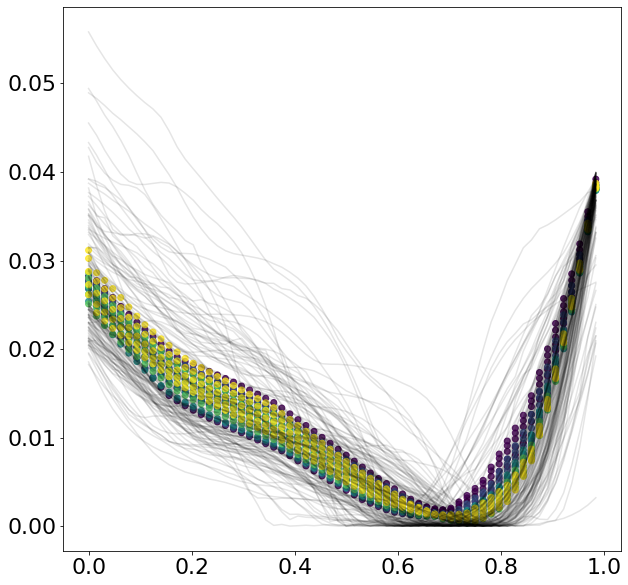

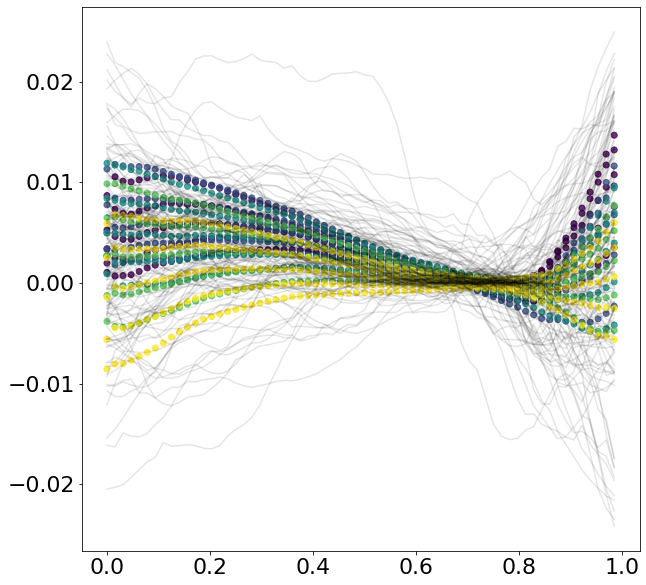

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
(155, 3)
[-2.6187158 -2.6100488 -2.4455287] [2.7362103 2.389297  3.55182  ]
[[ 0.          0.         -2.61004877 -2.44552875]
 [ 0.          0.         -2.61004877 -0.94619155]
 [ 0.          0.         -2.61004877  0.55314565]
 ...
 [ 0.984375    0.          2.38929701  0.55314565]
 [ 0.984375    0.          2.38929701  2.05248284]
 [ 0.984375    0.          2.38929701  3.55182004]]
shape is  (1600, 7)
shape is  (1600, 7)


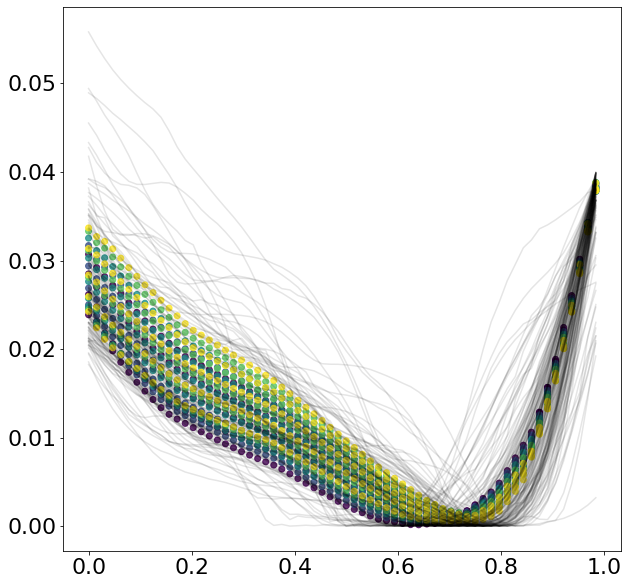

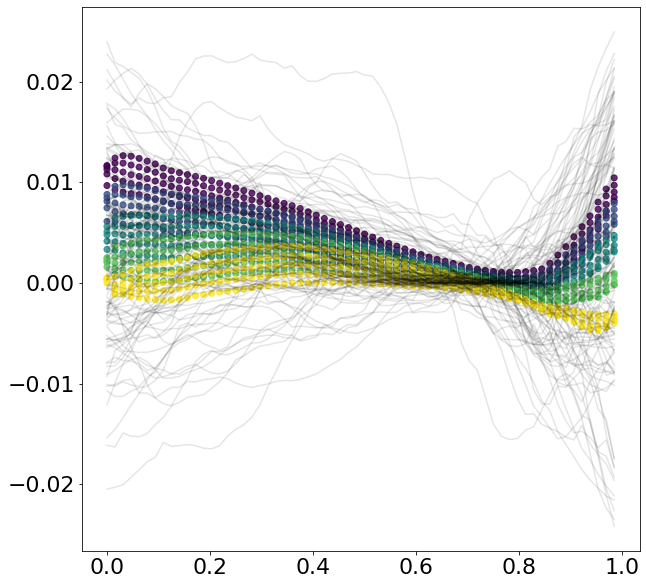

trainedmodels/banana_lat3_curvreg0.001_beta0.001_20220209-120436
(155, 3)
[-2.8922634 -2.7403736 -2.334646 ] [2.819046  2.6932473 3.0384707]
[[ 0.         -2.89226341  0.         -2.33464599]
 [ 0.         -2.89226341  0.         -0.9913668 ]
 [ 0.         -2.89226341  0.          0.35191238]
 ...
 [ 0.984375    2.81904602  0.          0.35191238]
 [ 0.984375    2.81904602  0.          1.69519156]
 [ 0.984375    2.81904602  0.          3.03847075]]
shape is  (1600, 7)
shape is  (1600, 7)


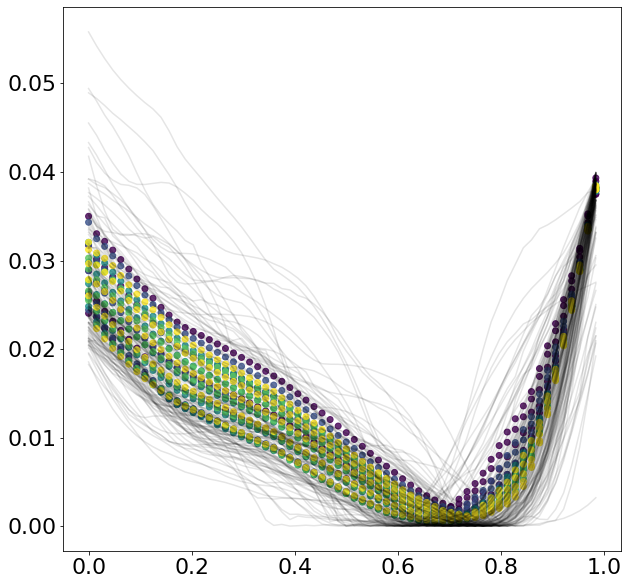

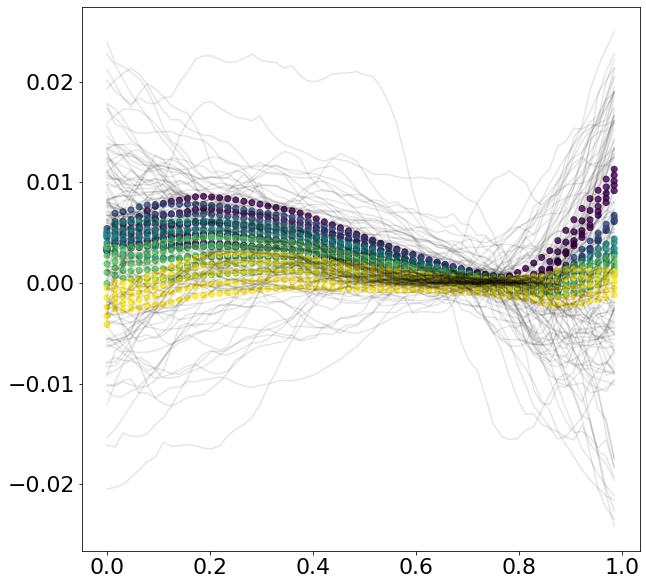

In [24]:
for latinds in [[0,1],
                [1,2],
                [0,2]]:
    for modelstring in all_models:
        print(modelstring)
        loaded_mod = lm.load_model(modelstring)
        loaded_vae = loaded_mod
        latent_dim = loaded_mod.latent_dim
        #x,mu,logvar, noiasy_mu, t
        embeds = np.array([loaded_vae.forward(t_all_points[i,:,1:], t_all_points[i,:,:1])[3].detach().numpy() for i in range(len(t_all_points))])
        embeds = embeds[:,0,:]
        print(embeds.shape)
        latmins = np.min(embeds,axis=0)
        latmaxs = np.max(embeds,axis=0)
        print(latmins,latmaxs)

        sweep = make_grid_points(num_dims = latent_dim+1,latmins=latmins,latmaxs=latmaxs,latinds=latinds)
        print(sweep)
        sweepdecodedx, sweepdecodedt = loaded_vae.decode(torch.tensor(sweep[:,1:], dtype=torch.float32),
                                         torch.tensor(sweep[:,:1], dtype=torch.float32),
                                        )
        sweepdecodedx=sweepdecodedx.detach().cpu().numpy()
        print("shape is ", sweepdecodedx.shape)
        sweepdecodedx = unscale_poses(sweepdecodedx)
        print("shape is ", sweepdecodedx.shape)
        sweepdecodedt=sweepdecodedt.detach().cpu().numpy()
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()#projection='3d')
        p=ax.scatter(sweepdecodedt[:],sweepdecodedx[:,2],  alpha=0.8,c=sweep[:,(latinds[0]+1)])
        #p=ax.scatter(all_poses[:,0],all_poses[:,2+1], s=2, alpha=0.2,c="k")
        p=ax.plot(all_points[:,:,0].T,all_points[:,:,2+1].T, alpha=0.1,c="k")
        plt.savefig("modeledHeightOverTime.jpeg")
        
        #scale = 60.
        #ax.set_xlim(-scale/2,scale/2)
        #ax.set_ylim(-5,-5+scale)
        plot_closure()
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()#projection='3d')
        p=ax.scatter(sweepdecodedt[:],sweepdecodedx[:,0],  alpha=0.8,c=sweep[:,(latinds[0]+1)])
        #p=ax.scatter(all_poses[:,0],all_poses[:,0+1], s=2, alpha=0.2,c="k")
        p=ax.plot(all_points[:,:,0].T,all_points[:,:,0+1].T, alpha=0.1,c="k")
        plt.savefig("modeledSideSlideOverTime.jpeg")
        #ax.set_xlim(-scale/2,scale/2)
        #ax.set_ylim(-scale/2,scale/2)
        plot_closure()